In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

from sklearn.utils import resample

from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.decomposition import PCA

In [41]:
df = pd.read_excel('default_of_credit_card_clients.xls', header=1, sep='\t')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [42]:
df.rename({'default payment next month':'DEFAULT'}, axis='columns', inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [43]:
df.drop('ID', axis=1, inplace=True)

In [44]:
# identify the missing data
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

In [45]:
 df['SEX'].unique()

array([2, 1], dtype=int64)

In [46]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

In [47]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0], dtype=int64)

In [48]:
len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)])

68

In [49]:
len(df)

30000

In [50]:
#missing data is 0.25% of the total data
df_no_missing = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]
print(len(df_no_missing))
print(df_no_missing['EDUCATION'].unique())
print(df_no_missing['MARRIAGE'].unique())

29932
[2 1 3 5 4 6]
[1 2 3]


In [51]:
# downsample the data, as SVM suooprts well with low numbered samples
df_no_default = df_no_missing.loc[df_no_missing['DEFAULT'] == 0]
df_default = df_no_missing.loc[df_no_missing['DEFAULT'] == 1]

df_no_default_downsampled = resample(df_no_default,
                                    replace=False,
                                    n_samples=1000,
                                    random_state=42)

df_default_downsampled = resample(df_default,
                                    replace=False,
                                    n_samples=1000,
                                    random_state=42)

print(len(df_no_default_downsampled))
print(len(df_default_downsampled))

df_downsampled = pd.concat([df_no_default_downsampled, df_default_downsampled])
print(len(df_downsampled))

1000
1000
2000


In [52]:
# create train and test data
X = df_downsampled.drop('DEFAULT', axis=1).copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000,2,3,1,28,0,0,0,0,-2,...,50000,0,0,0,2500,1000,0,0,0,0
4678,170000,1,3,1,29,0,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,180000,2,2,1,29,0,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,210000,2,2,2,32,-2,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
17535,190000,2,3,1,45,0,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [53]:
y = df_downsampled['DEFAULT'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

In [54]:
# One Hot encoding, encode the categorical variables
# Sex, Education, marriage,PAY_
X_encoded = pd.get_dummies(X, columns=['SEX','EDUCATION', 'MARRIAGE', 'PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,...,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,...,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,...,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,...,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,...,0,0,0,1,0,0,0,0,0,0


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [56]:
#build teh svm model
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

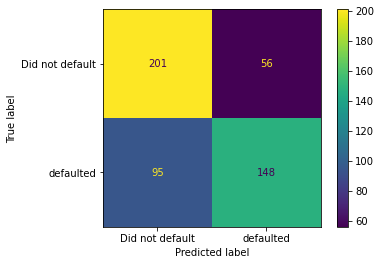

In [57]:
plot_confusion_matrix(clf_svm,
                     X_test_scaled,
                     y_test,
                     values_format='d',
                     display_labels=['Did not default', 'defaulted'])

In [58]:
print('Did not default predicted accuracy - %s', (201 / 257) * 100)
print('default predicted accuracy - %s', (148 / 243) * 100)

Did not default predicted accuracy - %s 78.21011673151752
default predicted accuracy - %s 60.90534979423868


In [59]:
# optimize the parameters to improve the above accuracy.
# using GridSearchCV (Cross validation)
import time
tic = time.perf_counter()
param_grid = [
    {'C' : [0.5, 1, 10, 100], # for redgularization, should be > 0
     'gamma' : ['scale', 1, 0.1, 0.01, 0.001, 0.0001], # the gamma value in the RBF kernel.
     'kernel' : ['rbf']
    }
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=2,
    scoring='accuracy',
    # other possible values for scoring
    # balanced_accuracy, f1, f1_micro, f1_macro, f1_weighted, roc_auc 
    verbose=0 # verbose=2 gives all the CV process steps details
    )

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)
toc = time.perf_counter()
print(f"Completed in {toc - tic:0.4f} seconds")

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Completed in 3.9168 seconds


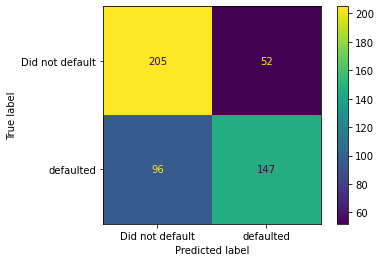

In [60]:
# rebuild the model with the optimal params we got from CV
clf_svm = SVC(random_state=42, C=100, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

plot_confusion_matrix(clf_svm,
                     X_test_scaled,
                     y_test,
                     values_format='d',
                     display_labels=['Did not default', 'defaulted'])

In [61]:
print('Did not default predicted accuracy - %s', (205 / 257) * 100)
print('default predicted accuracy - %s', (147 / 243) * 100)

Did not default predicted accuracy - %s 79.76653696498055
default predicted accuracy - %s 60.49382716049383


In [62]:
len(df_downsampled.columns)

24

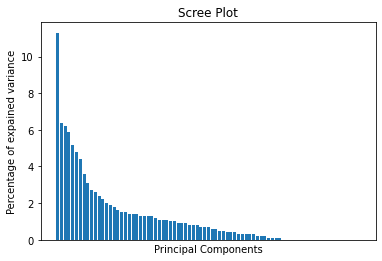

In [63]:
# plotting the SVM hyperplane with 24 features will be complicated
# using PCA to downsize to two features.
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# plot the PCA, explaning about the variance for each feature
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False
    )

plt.ylabel('Percentage of expained variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [64]:
# from the above it shows, PC1 has lot of variance but not the others.
# try to build new model with PC1, PC2
X_train_pca.shape

(1500, 81)

In [65]:
train_pc1_cords = X_train_pca[:, 0]
train_pc2_cords = X_train_pca[:, 1]
# considered the two features pc1, pc2

# sclae the data and fit with SVM 
pca_train_scaled = scale(np.column_stack((train_pc1_cords, train_pc2_cords)))

param_grid = [
     {'C' : [0.5, 1, 10, 100], # for redgularization, should be > 0
     'gamma' : ['scale', 1, 0.1, 0.01, 0.001, 0.0001], # the gamma value in the RBF kernel.
     'kernel' : ['rbf']
    }
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=2,
    scoring='accuracy',
    # other possible values for scoring
    # balanced_accuracy, f1, f1_micro, f1_macro, f1_weighted, roc_auc 
    verbose=0 # verbose=2 gives all the CV process steps details
    )

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)
toc = time.perf_counter()
print(f"Completed in {toc - tic:0.4f} seconds")

{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
Completed in 5.3189 seconds


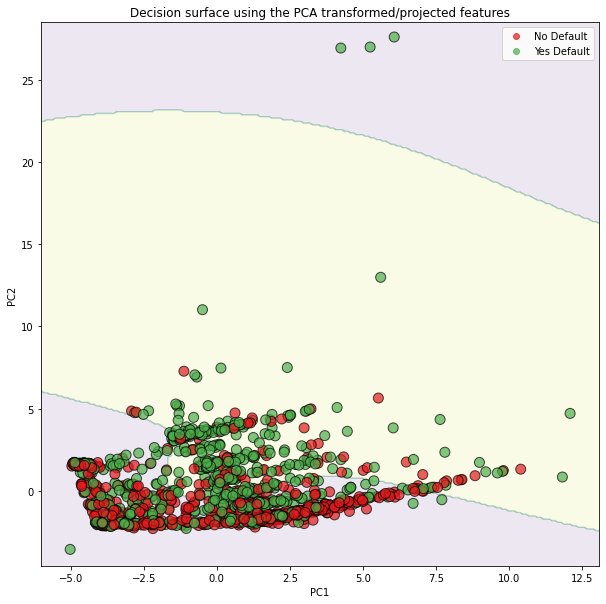

In [66]:
# built the SVc with the params.
clf_svm = SVC(random_state=42, C=1000, gamma=0.01)
clf_svm.fit(pca_train_scaled, y_train)

X_test_pca = pca.fit_transform(X_train_scaled)
test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]

# plot the hyperplane
x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                    np.arange(start=y_min, stop=y_max, step=0.1))
# classify with the decision boundary.
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

# Z has the all the predictions.
# reshape to test data,such that each prediction matches to the input
Z = Z.reshape(xx.shape)

fix, ax = plt.subplots(figsize=(10,10))
ax.contourf(xx, yy, Z, alpha=0.1)
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])
scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c = y_train, cmap=cmap, s=100, edgecolors='k', alpha=0.7)

legend = ax.legend(scatter.legend_elements()[0],
                  scatter.legend_elements()[1],
                  loc='upper right')
legend.get_texts()[0].set_text('No Default')
legend.get_texts()[1].set_text('Yes Default')

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision surface using the PCA transformed/projected features')
plt.show()
